# 🔍 Optimal Skills for Data Analysts – Integrated Analysis

This notebook combines prior analyses to identify the **most optimal skills** for Data Analysts in the US by considering:

1. **Skill demand** (% of job postings requesting a skill)
2. **Median salary** for each skill
3. **Trends over time** (consistency and growth of demand)

The goal is to highlight skills that maximize **both employability and earning potential**, helping job seekers make strategic skill investments.

> **Definition of “Optimal” Skills:**  
> Skills that combine **high demand** with **above-average pay**, offering the strongest return on learning investment.

---

## 🛠 **Setup: Import Libraries and Load Data**

We will use the **full job postings dataset (2023–2024)** from [datanerd.tech](https://datanerd.tech) to analyze US Data Analyst skills.  

> **Dataset Source:**  
> - Originally part of the Python Data Analyst course, extended with full dataset covering 2023 through the latest update.  
> - File: `job_postings_flat.csv` (local CSV, not pushed to GitHub due to size >100MB).  
> - Updated twice a year to reflect the most recent job trends.

We filter to **2024** to focus on the most recent complete year, ensuring our analysis of skill demand and salary is current and relevant.

In [1]:
# Import required libraries
import ast
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Configure data source - Base project directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Full path to CSV using relative structure
CSV_PATH = os.path.join(BASE_DIR, 'data', 'Job_Postings_2023-2024.csv')

# Load data automatically
if os.path.exists(CSV_PATH):
    print(f"Loading local CSV from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
else:
    print("Local CSV not found. Loading dataset from Hugging Face...")
    dataset = load_dataset('lukebarousse/data_jobs')
    df = dataset['train'].to_pandas()

# Clean and prepare data
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df = df[df['job_posted_date'].dt.year == 2024]

print(f"Data loaded successfully!")

Loading local CSV from '/Users/nadia_rozman/Python_for_Data_Analytics/Project/data/Job_Postings_2023-2024.csv'...
Data loaded successfully!


## 📊 **Filter Dataset for US Data Analyst Jobs**

Filter the dataset to only US Data Analyst jobs, drop missing salaries, and explode the `job_skills` column so each skill is in its own row.

In [2]:
# Filter for US Data Analyst jobs with salary data
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

# Explode skills to individual rows
df_DA_US_exploded = df_DA_US.explode('job_skills')
df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
787774,100000.0,sql
787774,100000.0,python
787774,100000.0,aws
787774,100000.0,spark
787774,100000.0,kafka


## 📈 **Calculate Percent of Job Postings that Have Skills**

Compute **skill counts**, **median salary**, and **percent of job postings** per skill.  
Filter out skills that appear in zero postings.

In [3]:
# Calculate skill count, median salary, and percentage of jobs
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median'])
df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)
df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100
df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
airflow,120,100000.00,2.227999
airtable,2,110380.75,0.037133
alteryx,84,95000.00,1.559599
angular,2,115950.00,0.037133
ansible,9,100000.00,0.167100
...,...,...,...
wire,7,80000.00,0.129967
word,345,77000.00,6.405496
workfront,2,97500.00,0.037133


## 💹 **Median Salary vs Percent Skill Demand**

Visualize the relationship between **skill demand** and **median salary** for high-demand skills (appearing in >5% of postings).

> This visualization highlights the tradeoff between employability and compensation, revealing which skills offer the strongest risk-adjusted returns.

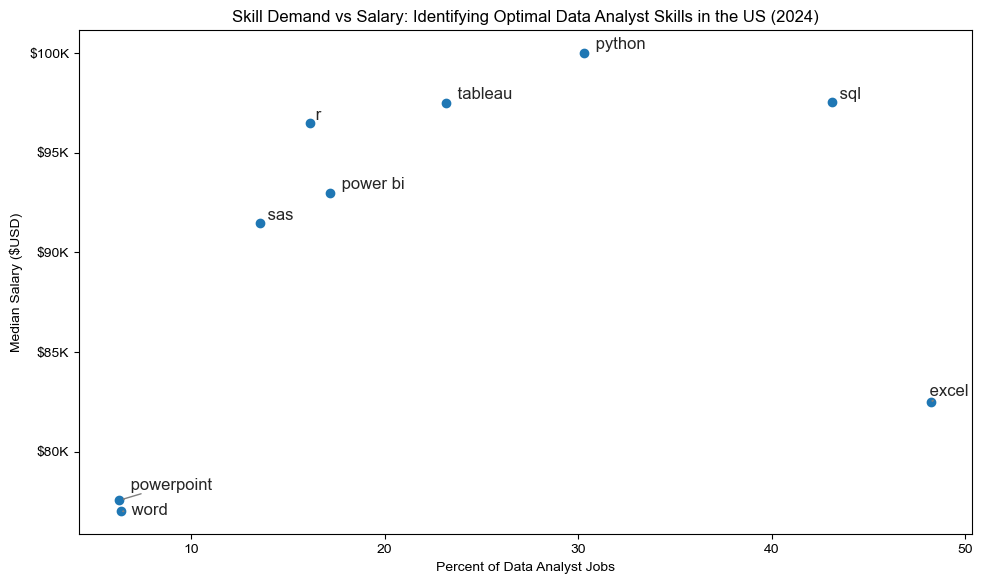

Figure saved successfully!


In [ ]:
# Scatter plot of skill demand vs salary for high-demand skills
from adjustText import adjust_text
import os
import matplotlib.pyplot as plt
import seaborn as sns

skill_limit = 5
df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

fig, ax = plt.subplots(figsize=(10,6))

sns.set_theme(style='ticks')
ax.scatter(
    df_DA_skills_high_demand['skill_percent'],
    df_DA_skills_high_demand['median_salary']
)

ax.set_xlabel('Percent of Data Analyst Jobs')
ax.set_ylabel('Median Salary ($USD)')
ax.set_title('Skill Demand vs Salary: Identifying Optimal Data Analyst Skills in the US (2024)')

# Format y-axis as salary
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

# Add labels to points
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(ax.text(
        df_DA_skills_high_demand['skill_percent'].iloc[i],
        df_DA_skills_high_demand['median_salary'].iloc[i],
        " " + txt
    ))

# Adjust text to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='gray'))

fig.tight_layout()

# Save figure
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)

FIG_FILENAME = '5_Most_Optimal_Skills_for_Data_Analysts.png'
FIG_PATH = os.path.join(IMAGES_DIR, FIG_FILENAME)

plt.savefig(FIG_PATH, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved successfully!")

## 🎨 **Bonus: Coloring by Technology**

We enhance the scatter plot by grouping skills by **technology category**, helping to identify career pathways.


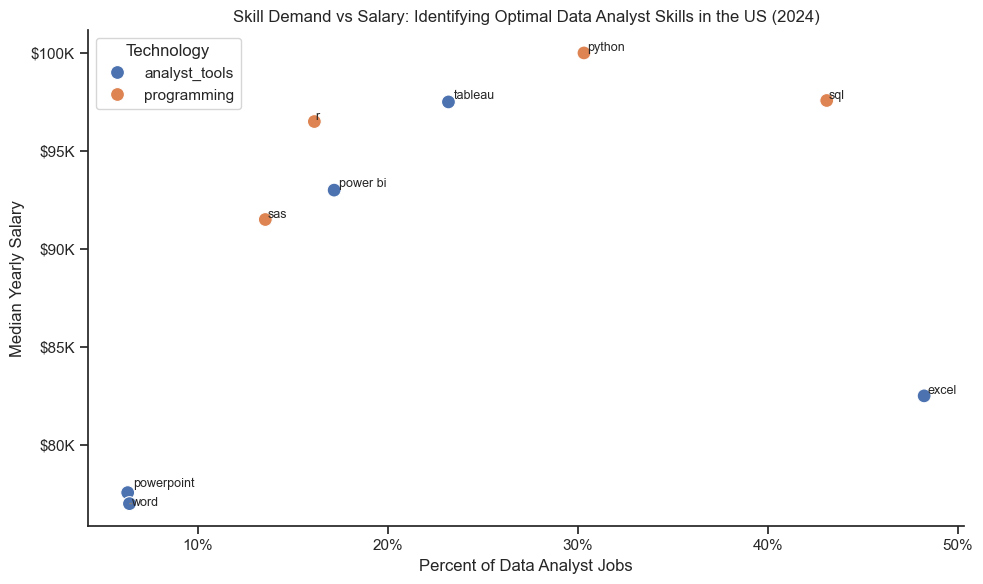

Figure saved successfully!


In [5]:
# Extract technology-skill mapping from raw data
df_technology = (
    df['job_type_skills']
    .drop_duplicates()
    .dropna()
)

# Combine all technology-skill dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert stringified dict to actual dict
    for tech, skills in row_dict.items():
        technology_dict.setdefault(tech, []).extend(skills)

# Remove duplicate skills per technology
technology_dict = {
    tech: list(set(skills))
    for tech, skills in technology_dict.items()
}

# Convert technology dictionary to exploded DataFrame
df_technology = (
    pd.DataFrame(technology_dict.items(), columns=['technology', 'skills'])
    .explode('skills')
)

# Merge skill metrics with technology categories
df_DA_skills_tech = df_DA_skills.merge(
    df_technology,
    left_on='job_skills',
    right_on='skills',
    how='left'
)

# Filter for high-demand skills only
df_DA_skills_tech_high_demand = df_DA_skills_tech[
    df_DA_skills_tech['skill_percent'] > skill_limit
]

# PLOT SCATTER WITH TECHNOLOGY COLORING
import os
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='ticks')

# Scatter plot
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology',
    s=100,
    ax=ax
)
sns.despine(ax=ax)

# Add skill labels with automatic overlap adjustment
texts = []
for i, skill in enumerate(df_DA_skills_high_demand.index):
    texts.append(
        ax.text(
            df_DA_skills_high_demand['skill_percent'].iloc[i],
            df_DA_skills_high_demand['median_salary'].iloc[i],
            skill,
            fontsize=9
        )
    )

adjust_text(
    texts,
    ax=ax,
    arrowprops=dict(arrowstyle='->', color='gray')
)

ax.set_xlabel('Percent of Data Analyst Jobs')
ax.set_ylabel('Median Yearly Salary')
ax.set_title('Skill Demand vs Salary: Identifying Optimal Data Analyst Skills in the US (2024)')
ax.legend(title='Technology')

# Format axes
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

fig.tight_layout()

# Save figure
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)

# Output file name
FIG_FILENAME = '6_Most_Optimal_Skills_for_Data_Analysts_with_Tech.png'
FIG_PATH = os.path.join(IMAGES_DIR, FIG_FILENAME)

plt.savefig(FIG_PATH, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved successfully!")

## 📌 **Key Takeaways**

### **SQL and Python Form the "High Value, High Demand" Sweet Spot**
**SQL** (46% demand, $97K) and **Python** (27% demand, $101K) occupy the optimal quadrant—offering both strong employability and above-average compensation. SQL's 46% presence makes it nearly universal, while Python's $101K median represents the highest salary among high-demand skills. Together, they define the essential skill foundation that maximizes both interview callbacks and earning potential.

### **Programming Skills Command a $6K-$10K Premium Over Analyst Tools**
Programming technologies (Python $101K, R $97K, SAS $91K) consistently outpace analyst-focused tools (Tableau $98K, Power BI $92K, Excel $83K) in compensation. Python's **$101K median** sits 18% above Excel's **$83K**, revealing that *programming capability*—even at basic levels—signals higher-value work and commands measurable salary premiums in Data Analyst roles.

### **Microsoft Office Tools Provide Strong Market Access**
Excel (50% demand, $83K), Word (7% demand, $77K), and PowerPoint (6% demand, $77K) are excellent entry points into the data field. Excel's presence in half of all postings makes it invaluable for landing initial opportunities. While these tools provide strong foundational access to the job market, pairing them with technical skills like Python or SQL unlocks significantly higher compensation tiers.

### **Visualization Tools Offer Balanced Market Positioning**
Tableau (23% demand, $98K) and Power BI (16% demand, $92K) deliver solid demand with competitive pay. Tableau's broader adoption (7 percentage points higher) and slightly higher median ($6K more) gives it a marginal edge, though both tools provide strong value for building stakeholder-facing analytics capabilities. Either choice positions you well for business intelligence roles.

### **Statistical Tools Serve Specialized Analytics Needs**
R (13% demand, $97K) and SAS (11% demand, $91K) occupy an important niche for statistical analysis and research-oriented roles. R's $97K median matches SQL despite appearing in only 13% of jobs, suggesting it serves more specialized, technically demanding positions. These tools excel in academic, pharmaceutical, and research contexts where statistical rigor is paramount.

### **Two Distinct Technology Career Paths Emerge**
The scatter plot reveals exciting specialization opportunities:
- **Programming-oriented roles** (Python, R, SAS) cluster in the **$91K-$101K range**
- **Business intelligence roles** (Tableau, Power BI, Excel, Word, PowerPoint) span **$77K-$98K**

This pattern suggests clear career pathways: technical programming roles and business-facing analytics roles each offer distinct value propositions, allowing professionals to align skills with their interests and strengths.

### **The 10% Demand Threshold Identifies Market-Validated Skills**
Skills appearing in >10% of postings (SQL, Excel, Python, Tableau, Power BI, R, SAS) represent market-validated investments with strong job availability. This threshold helps prioritize learning toward skills with proven employer demand, ensuring your skill development aligns with real market needs.

---

### 💼 **Optimal Skill Investment Strategy**

Based on the demand-salary matrix, here's the evidence-based learning priority:

**Tier 1: Essential Foundation (Build First)**
1. **SQL** - 46% demand, $97K median
   - *Why:* Appears in nearly half of all jobs; excellent salary; universally valued
   - *Impact:* Maximizes opportunities while maintaining strong earning potential
   
2. **Python** - 27% demand, $101K median  
   - *Why:* Highest salary among high-demand skills; versatile across analytics, engineering, and data science
   - *Impact:* Best compensation among accessible skills; opens doors to technical career paths

**Tier 2: Strategic Differentiation (Add Next)**
3. **Tableau** - 23% demand, $98K median
   - *Why:* Most established visualization platform; strong market presence
   - *Alternative:* Power BI (16% demand, $92K) for Microsoft-focused environments

**Tier 3: Specialization (Choose Based on Goals)**
4. **R** - 13% demand, $97K median
   - *Best for:* Statistical analysis, academic research, or specialized analytics roles
   - *Benefit:* Deep statistical capabilities and strong research community

5. **Excel** - 50% demand, $83K median
   - *Value:* Essential for market access; universally understood by stakeholders
   - *Strategy:* Leverage for initial opportunities while building complementary technical skills

---

### 🎯 **The Three-Skill Optimal Portfolio**

For maximum career leverage with focused learning investment:

**SQL + Python + Tableau = $95K-$105K opportunity space**

This combination:
- Addresses the most frequently requested skill sets in Data Analyst postings
- Positions you for strong compensation in the **$95K-$105K** range
- Balances broad employability (SQL at 46%, Python at 27%) with competitive pay
- Provides versatility across analytics, technical projects, and business communication

**Recommended Learning Allocation:**
- SQL: 40% of learning time (most requested, foundation of data work)
- Python: 40% of learning time (highest salary impact, broad applications)
- Tableau: 20% of learning time (valuable for stakeholder communication)

---

### 📊 **Key Strategic Insights**

**1. Balance is Achievable Between Employability and Compensation**
The data shows you don't need to sacrifice job opportunities for earning potential—SQL and Python deliver both. Strategic skill selection allows you to optimize for multiple objectives simultaneously.

**2. Programming Skills Open Higher Compensation Pathways**
The technology clustering shows that programming-oriented skills (Python, R, SAS) establish a strong compensation foundation. Early investment in coding literacy creates long-term value and career flexibility.

**3. Foundation Skills Enable Later Specialization**
Building core competencies in SQL, Python, and visualization tools creates optionality. Once established, you can explore specialized technical areas, business domains, or leadership paths based on your evolving interests.

**4. Excel Provides Excellent Entry Points**
Excel's 50% demand makes it an outstanding skill for launching your data career. It's the perfect complement to technical skills, ensuring you can communicate insights effectively across all organizational levels.

---

### 💡 **Strategic Considerations**

✅ **Focus builds expertise faster** - Master one visualization tool thoroughly rather than learning multiple superficially. Both Tableau and Power BI deliver similar outcomes.

✅ **Python offers broader applications** - With similar compensation to R ($101K vs $97K) but double the demand (27% vs 13%), Python provides greater career flexibility while maintaining earning potential.

✅ **Demand matters for early careers** - Skills appearing in 10%+ of postings ensure consistent job opportunities while you build experience and specialization.

✅ **Complementary skills compound value** - SQL + Python together create more value than either alone, as they enable both data access and advanced analysis.

---

### 🚀 **Suggested Learning Pathway**

**Month 1-2:** SQL fundamentals (queries, joins, aggregations, data transformation)  
**Month 3-4:** Python for data analysis (pandas, visualization libraries, basic scripting)  
**Month 5:** Tableau or Power BI (dashboards, interactive visualizations, business storytelling)  
**Month 6+:** Portfolio projects demonstrating SQL + Python + Tableau integration

**Expected Outcome:** Position yourself competitively for $90K-$100K Data Analyst roles with a well-balanced skill portfolio aligned to 2024 market demands.

---

### 🌟 **Final Recommendations**

**For Career Starters:**
Begin with Excel to understand data fundamentals, then systematically add SQL and Python. This progression builds from familiar territory while steadily increasing your technical capabilities and market value.

**For Career Changers:**
Focus on the SQL + Python + Tableau trio to quickly build a complete, market-relevant skill set. This combination addresses both technical requirements and business communication needs.

**For Career Advancers:**
If you already have SQL and Excel proficiency, Python becomes your highest-value investment for expanding into $100K+ opportunities. It opens pathways to data engineering, analytics engineering, and data science roles.

The analysis reveals that strategic skill development—focusing on high-impact combinations rather than collecting credentials—leads to optimal career outcomes. The goal isn't to learn everything, but to thoughtfully build capabilities that align market demand with personal career aspirations.